In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    get_info_experiment
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

def piecewise_linear_phi(y, bounds):
    x1, x2, x3, x4 = tf.unstack(bounds)
    iqr = (x3-x2)
    x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4, y5, y6, y7 = 0.1, 0.2, 0.4, 0.5, 0.82, 1, 1
    return tf.where(
        y <= x1, y1,
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, y4 + (y4-y3)/(x4-x3)*(y-x4),
                    tf.where(
                        y <= x5, y5 + (y5-y4)/(x5-x4)*(y-x5),
                        tf.where(
                            y <= x6, y6 + (y6-y5)/(x6-x5)*(y-x6), 
                            tf.where(
                                y <= x7, tf.ones_like(y), tf.ones_like(y) 
                            )
                        )
                    )
                )
            )
        )
    )

class SERA(tf.keras.losses.Loss):
    def __init__(self, bounds, T=100, name="sera_loss"):
        super().__init__(name=name)
        self.bounds = tf.constant(bounds, dtype=tf.float32)
        self.T = T
        self.thresholds = tf.linspace(0.0, 1.0, T + 1)
        # self.relevance = relevance_fn

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        errors = tf.square(y_pred - y_true)
        relevance = piecewise_linear_phi(y_true, self.bounds)

        total = tf.constant(0.0, dtype=tf.float32)
        for i in range(self.T + 1):
            t = self.thresholds[i]
            mask = relevance >= t
            masked_errors = tf.boolean_mask(errors, mask)
            if tf.size(masked_errors) > 0:
                weight = 0.5 if (i == 0 or i == self.T) else 1.0
                total += weight * tf.reduce_sum(masked_errors)

        return total / tf.cast(self.T, tf.float32)

def create_relevance_function(y):
    """
    Create a PCHIP-based relevance function φ(y) using adjusted boxplot bounds.
    """
    lower, median, upper = compute_adjusted_boxplot_bounds(y)
    
    # Extend with actual min/max to smooth edges
    # x = np.array([min(y), lower, median, upper, max(y)])
    x = np.array([lower, median, upper, max(y)])
    # if x[1] < x[0]:
    #     x[1] = (x[0]+ x[2])/2
    relevance = np.array([0, 0, 1.0, 1.0])

    # Ensure strictly increasing x by removing duplicate values
    x_unique, idx = np.unique(x, return_index=True)
    relevance_unique = relevance[idx]
    print(x_unique)
    print(relevance_unique)
    pchip = PchipInterpolator(x_unique, relevance_unique, extrapolate=True)
    return pchip

def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data


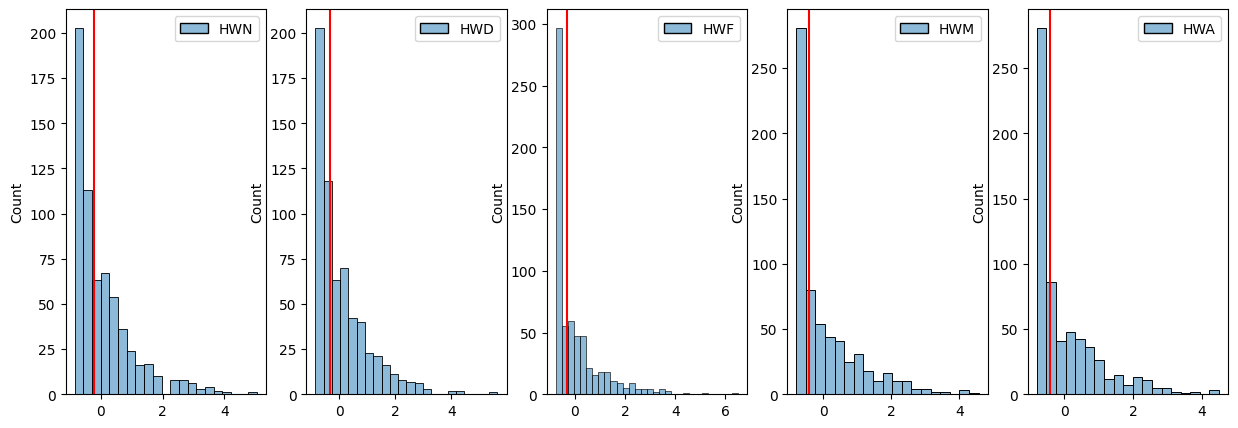

In [11]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i, index in enumerate(indices):
    sns.histplot(hws[[index]], ax=axs[i])
    axs[i].axvline(np.median(hws[[index]]), color='red')

In [16]:
hws_index = hws[["HWF"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
relevance = create_relevance_function(hws_index)

[-1.16928928 -0.30647585  4.56154759  6.49996949]
[0. 0. 1. 1.]


[-1.67198855 -0.2172401   3.78913747  5.04912742]
[0. 0. 1. 1.]
[-1.29087242 -0.34134773  5.64964021  6.57004164]
[0. 0. 1. 1.]
[-1.16928928 -0.30647585  4.56154759  6.49996949]
[0. 0. 1. 1.]
[-1.02853416 -0.42044333  4.56176381  9.27135903]
[0. 0. 1. 1.]
[-1.03912763 -0.40948925  4.49952694  8.84034871]
[0. 0. 1. 1.]


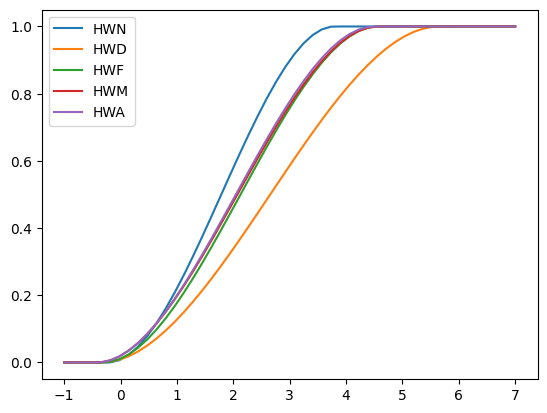

In [13]:
x = np.linspace(-1, 7)
for index in indices:
    hws_index = hws[[index]].to_numpy()
    hws_index = hws_index.reshape(hws_index.shape[0])
    relevance = create_relevance_function(hws_index)
    plt.plot(x, relevance(x), label=index)
plt.legend()
plt.show()


In [17]:
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
print(bounds)
f2 = piecewise_linear_phi(hws_index, bounds)

(-1.1692892810242344, -0.30647585455315646, 4.561547586528888, 6.499969486244418)


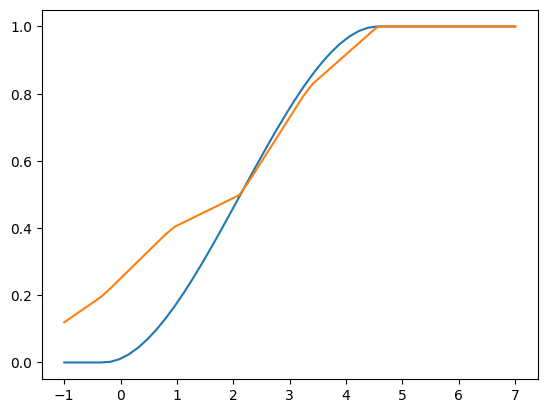

In [18]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi(x, bounds))

Epoch 1/200
6/6 [==============================] - 17s 709ms/step - loss: 25.1491 - mae: 0.9807 - val_loss: 22.3713 - val_mae: 1.1830
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 24.8917 - mae: 0.9606 - val_loss: 21.5683 - val_mae: 1.1583
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 23.6707 - mae: 0.9183 - val_loss: 20.7238 - val_mae: 1.1346
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 21.1648 - mae: 0.8801 - val_loss: 19.9167 - val_mae: 1.1101
Epoch 5/200
6/6 [==============================] - 0s 10ms/step - loss: 22.4432 - mae: 0.8966 - val_loss: 19.2320 - val_mae: 1.0862
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 20.8796 - mae: 0.8766 - val_loss: 18.6639 - val_mae: 1.0655
Epoch 7/200
6/6 [==============================] - 0s 9ms/step - loss: 21.5772 - mae: 0.8756 - val_loss: 18.1307 - val_mae: 1.0452
Epoch 8/200
6/6 [==============================] - 0s 10ms/step - loss: 19.38

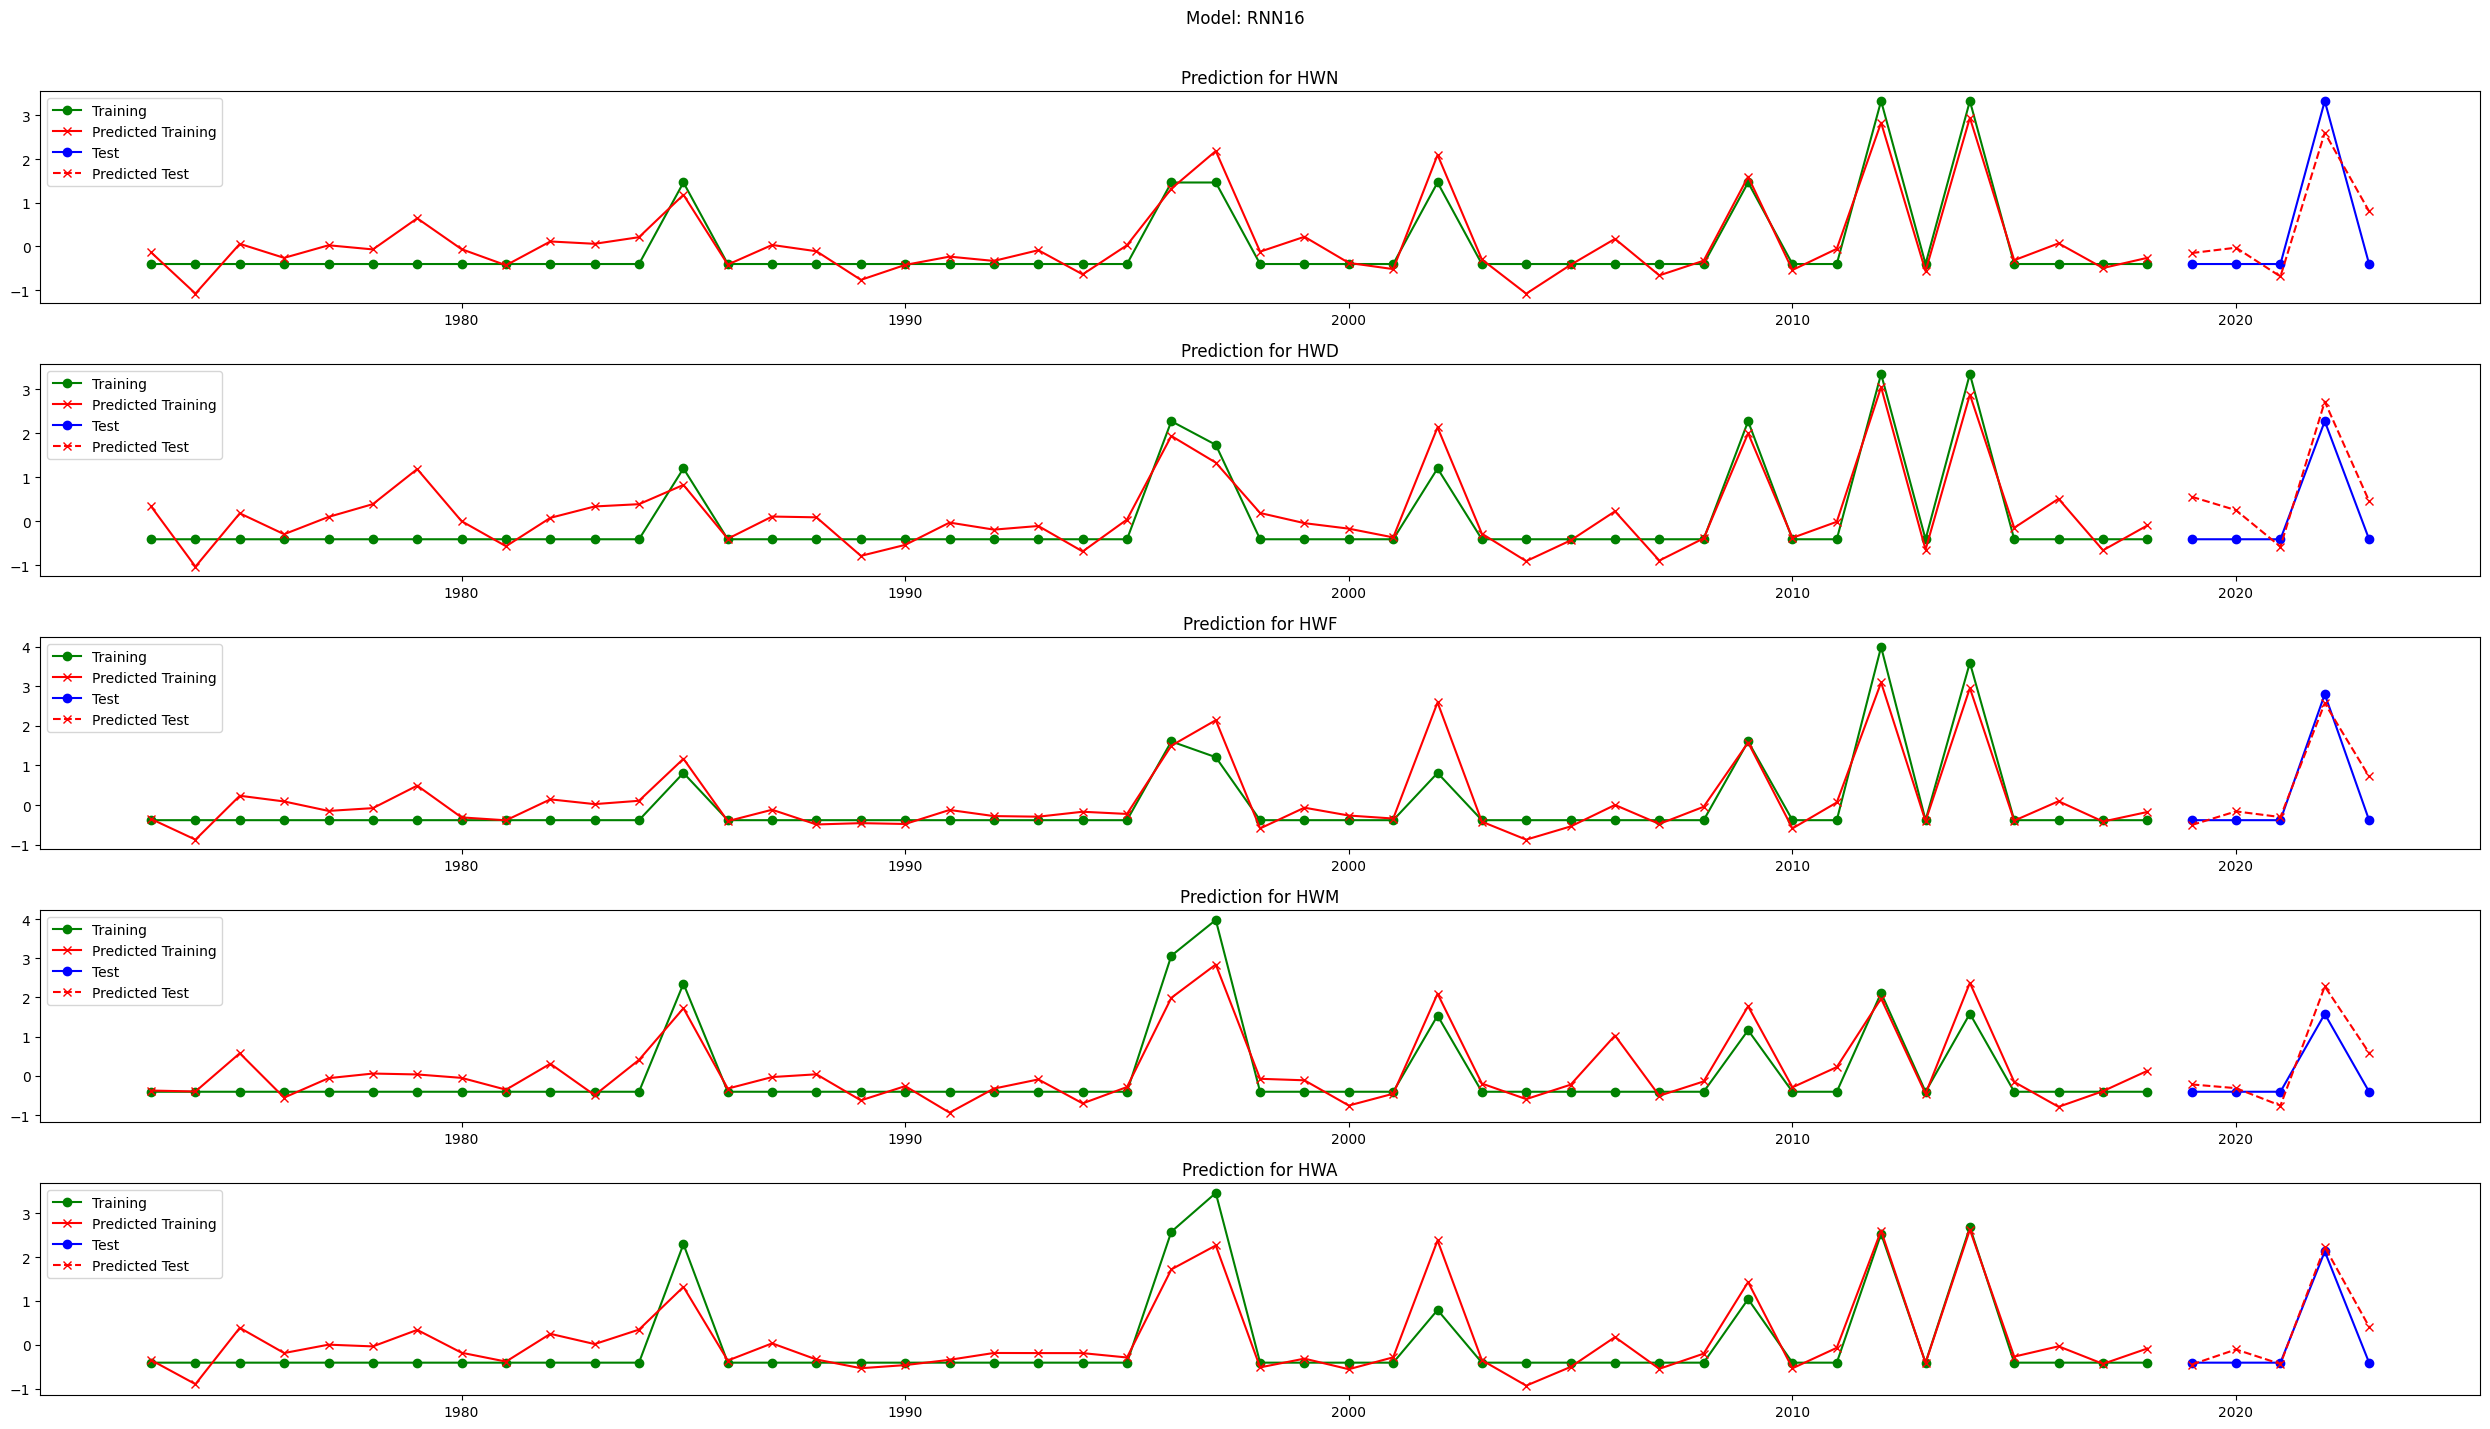

In [19]:
loss_fn = SERA(bounds=bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 659ms/step - loss: 21.4141 - mae: 0.9344 - val_loss: 10.3132 - val_mae: 1.0187
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 21.4685 - mae: 0.9295 - val_loss: 9.8303 - val_mae: 0.9980
Epoch 3/200
6/6 [==============================] - 0s 10ms/step - loss: 19.2103 - mae: 0.9264 - val_loss: 9.3507 - val_mae: 0.9759
Epoch 4/200
6/6 [==============================] - 0s 10ms/step - loss: 18.5285 - mae: 0.9046 - val_loss: 8.8915 - val_mae: 0.9565
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 19.1734 - mae: 0.9091 - val_loss: 8.5390 - val_mae: 0.9426
Epoch 6/200
6/6 [==============================] - 0s 10ms/step - loss: 17.5853 - mae: 0.9099 - val_loss: 8.2204 - val_mae: 0.9282
Epoch 7/200
6/6 [==============================] - 0s 10ms/step - loss: 17.4686 - mae: 0.9050 - val_loss: 7.9230 - val_mae: 0.9141
Epoch 8/200
6/6 [==============================] - 0s 9ms/step - loss: 18.2296 -

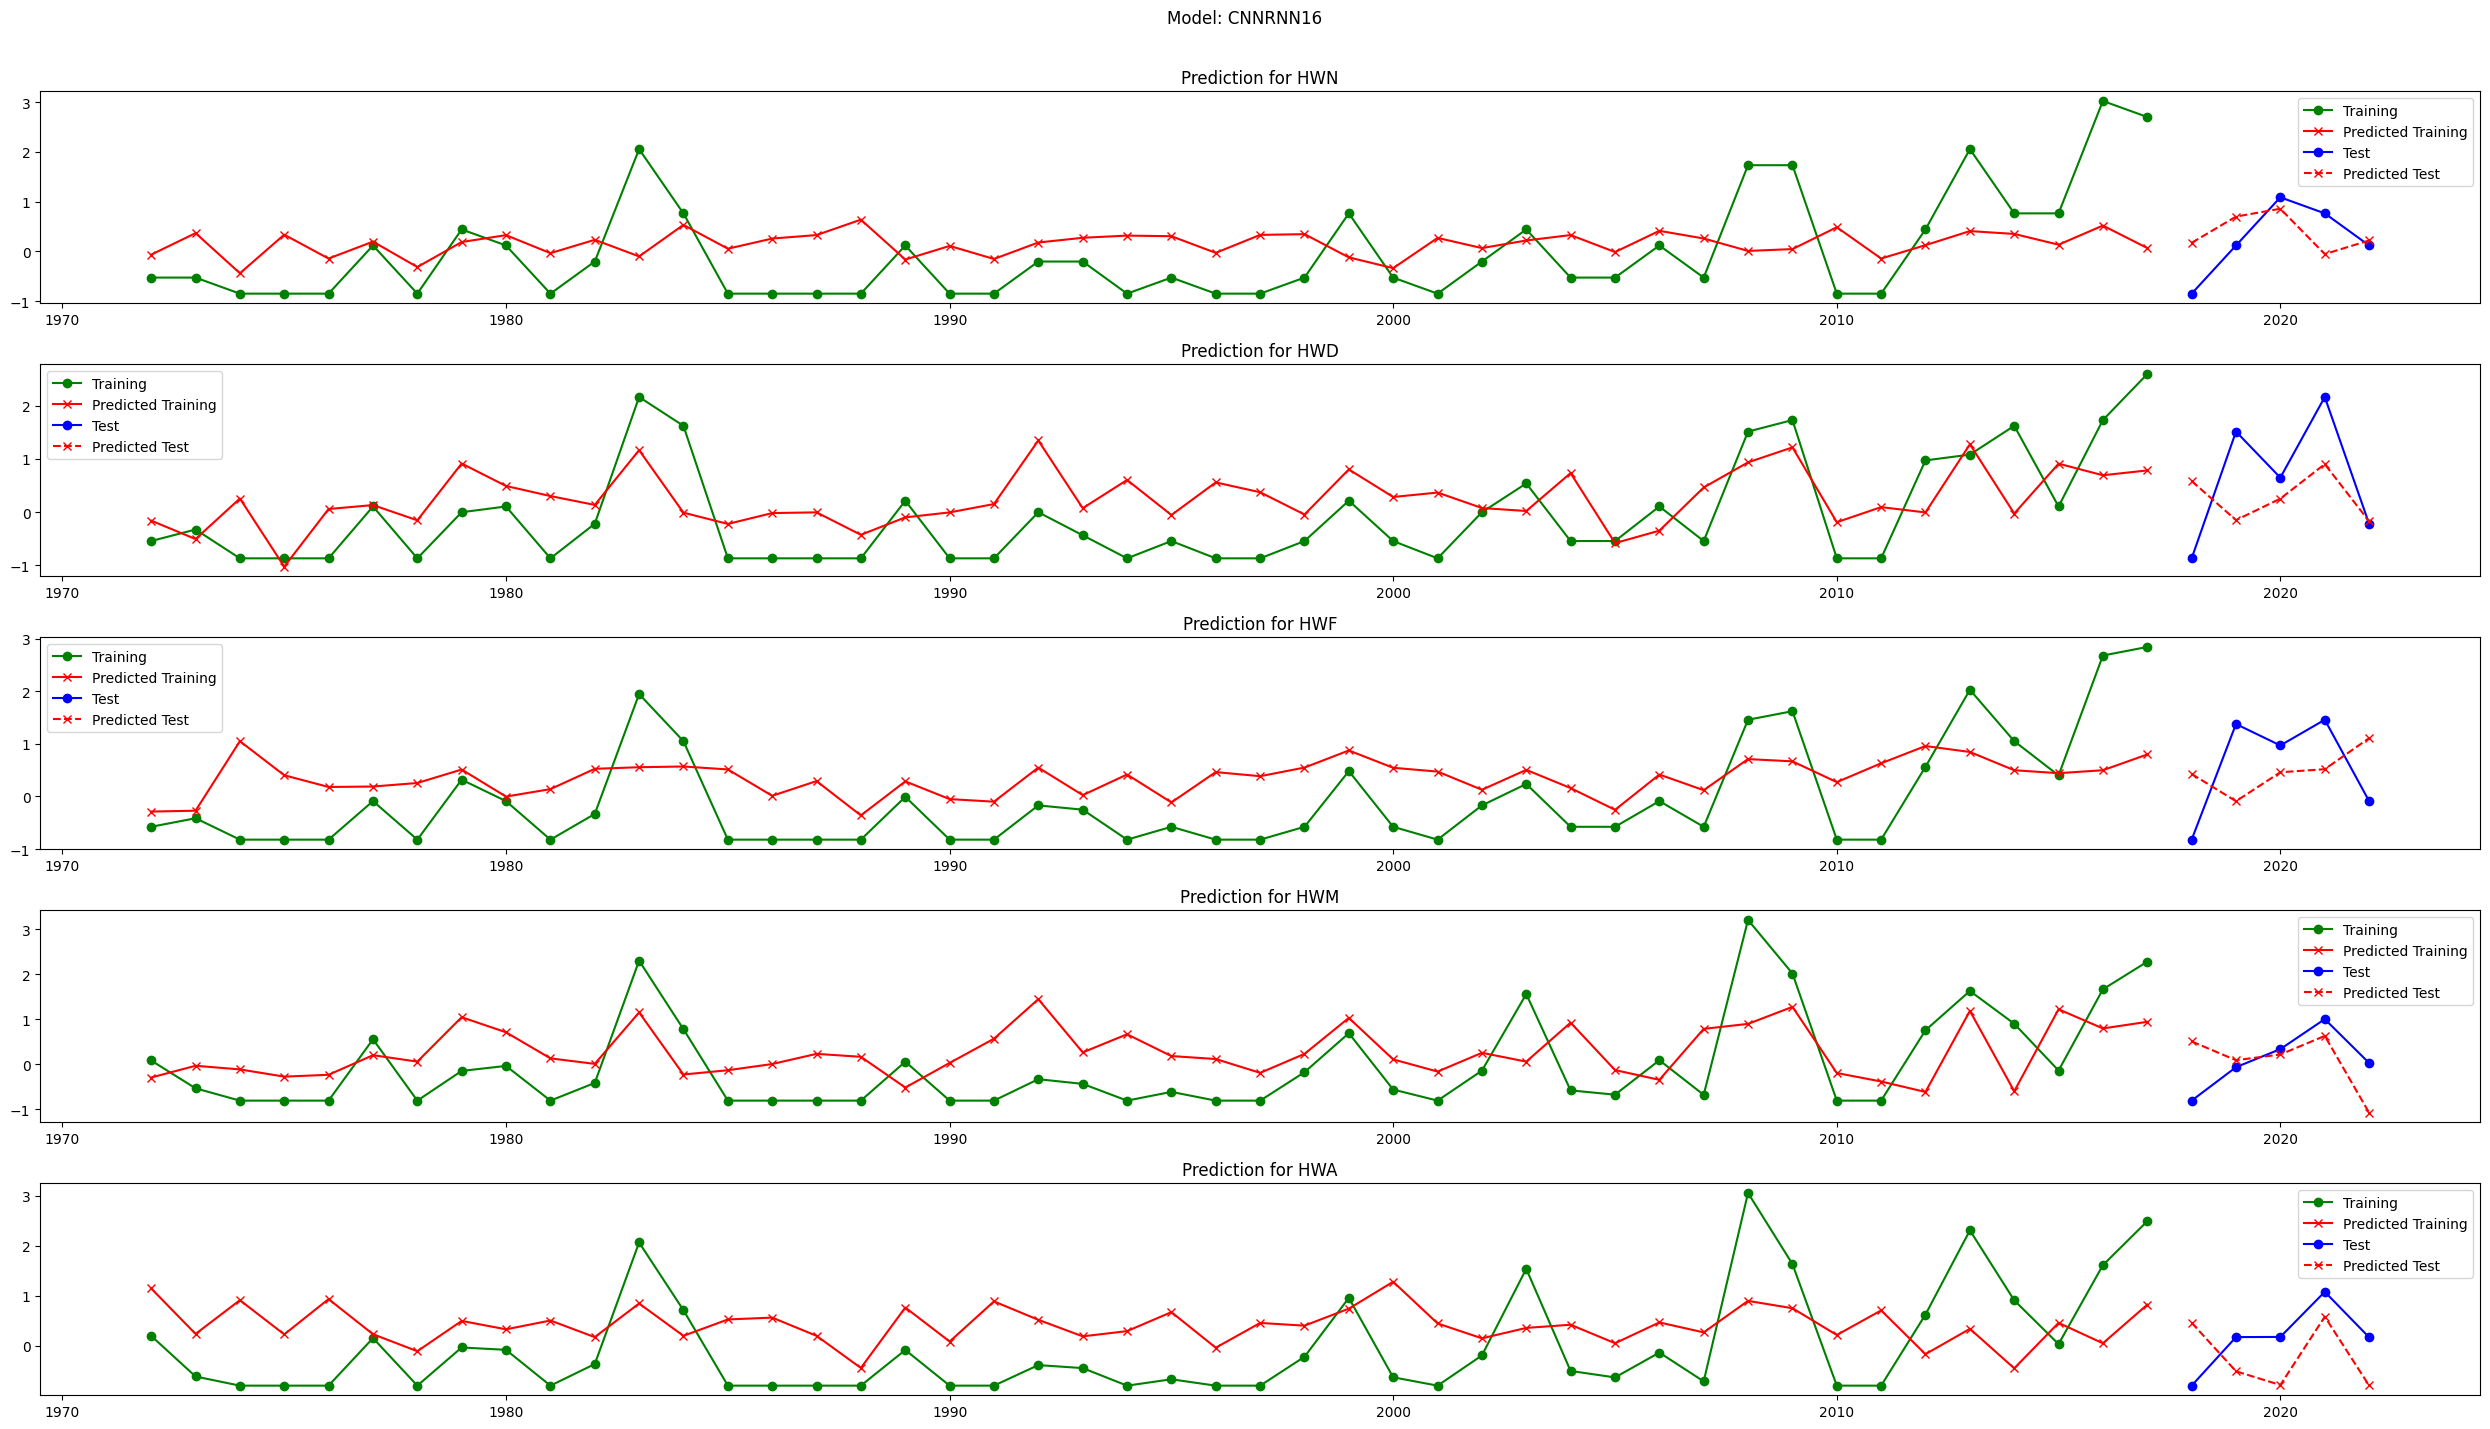

In [21]:
loss_fn = SERA(bounds=bounds,T=100)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16",loss_fn=loss_fn)
pred.compile_keras_model( metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 1s 32ms/step - loss: 1.3321 - val_loss: 1.0793
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 1.2216 - val_loss: 1.0444
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 1.1765 - val_loss: 1.0147
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 1.1637 - val_loss: 0.9920
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 1.1089 - val_loss: 0.9739
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 1.0893 - val_loss: 0.9624
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 1.0750 - val_loss: 0.9530
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 1.0513 - val_loss: 0.9482
Epoch 9/200
6/6 [==============================] - 0s 6ms/step - loss: 1.0223 - val_loss: 0.9440
Epoch 10/200
6/6 [==============================] - 0s 6ms/step - loss: 0.9783 - val_loss: 0.9411
Epoch 11/200
6/6 [==========

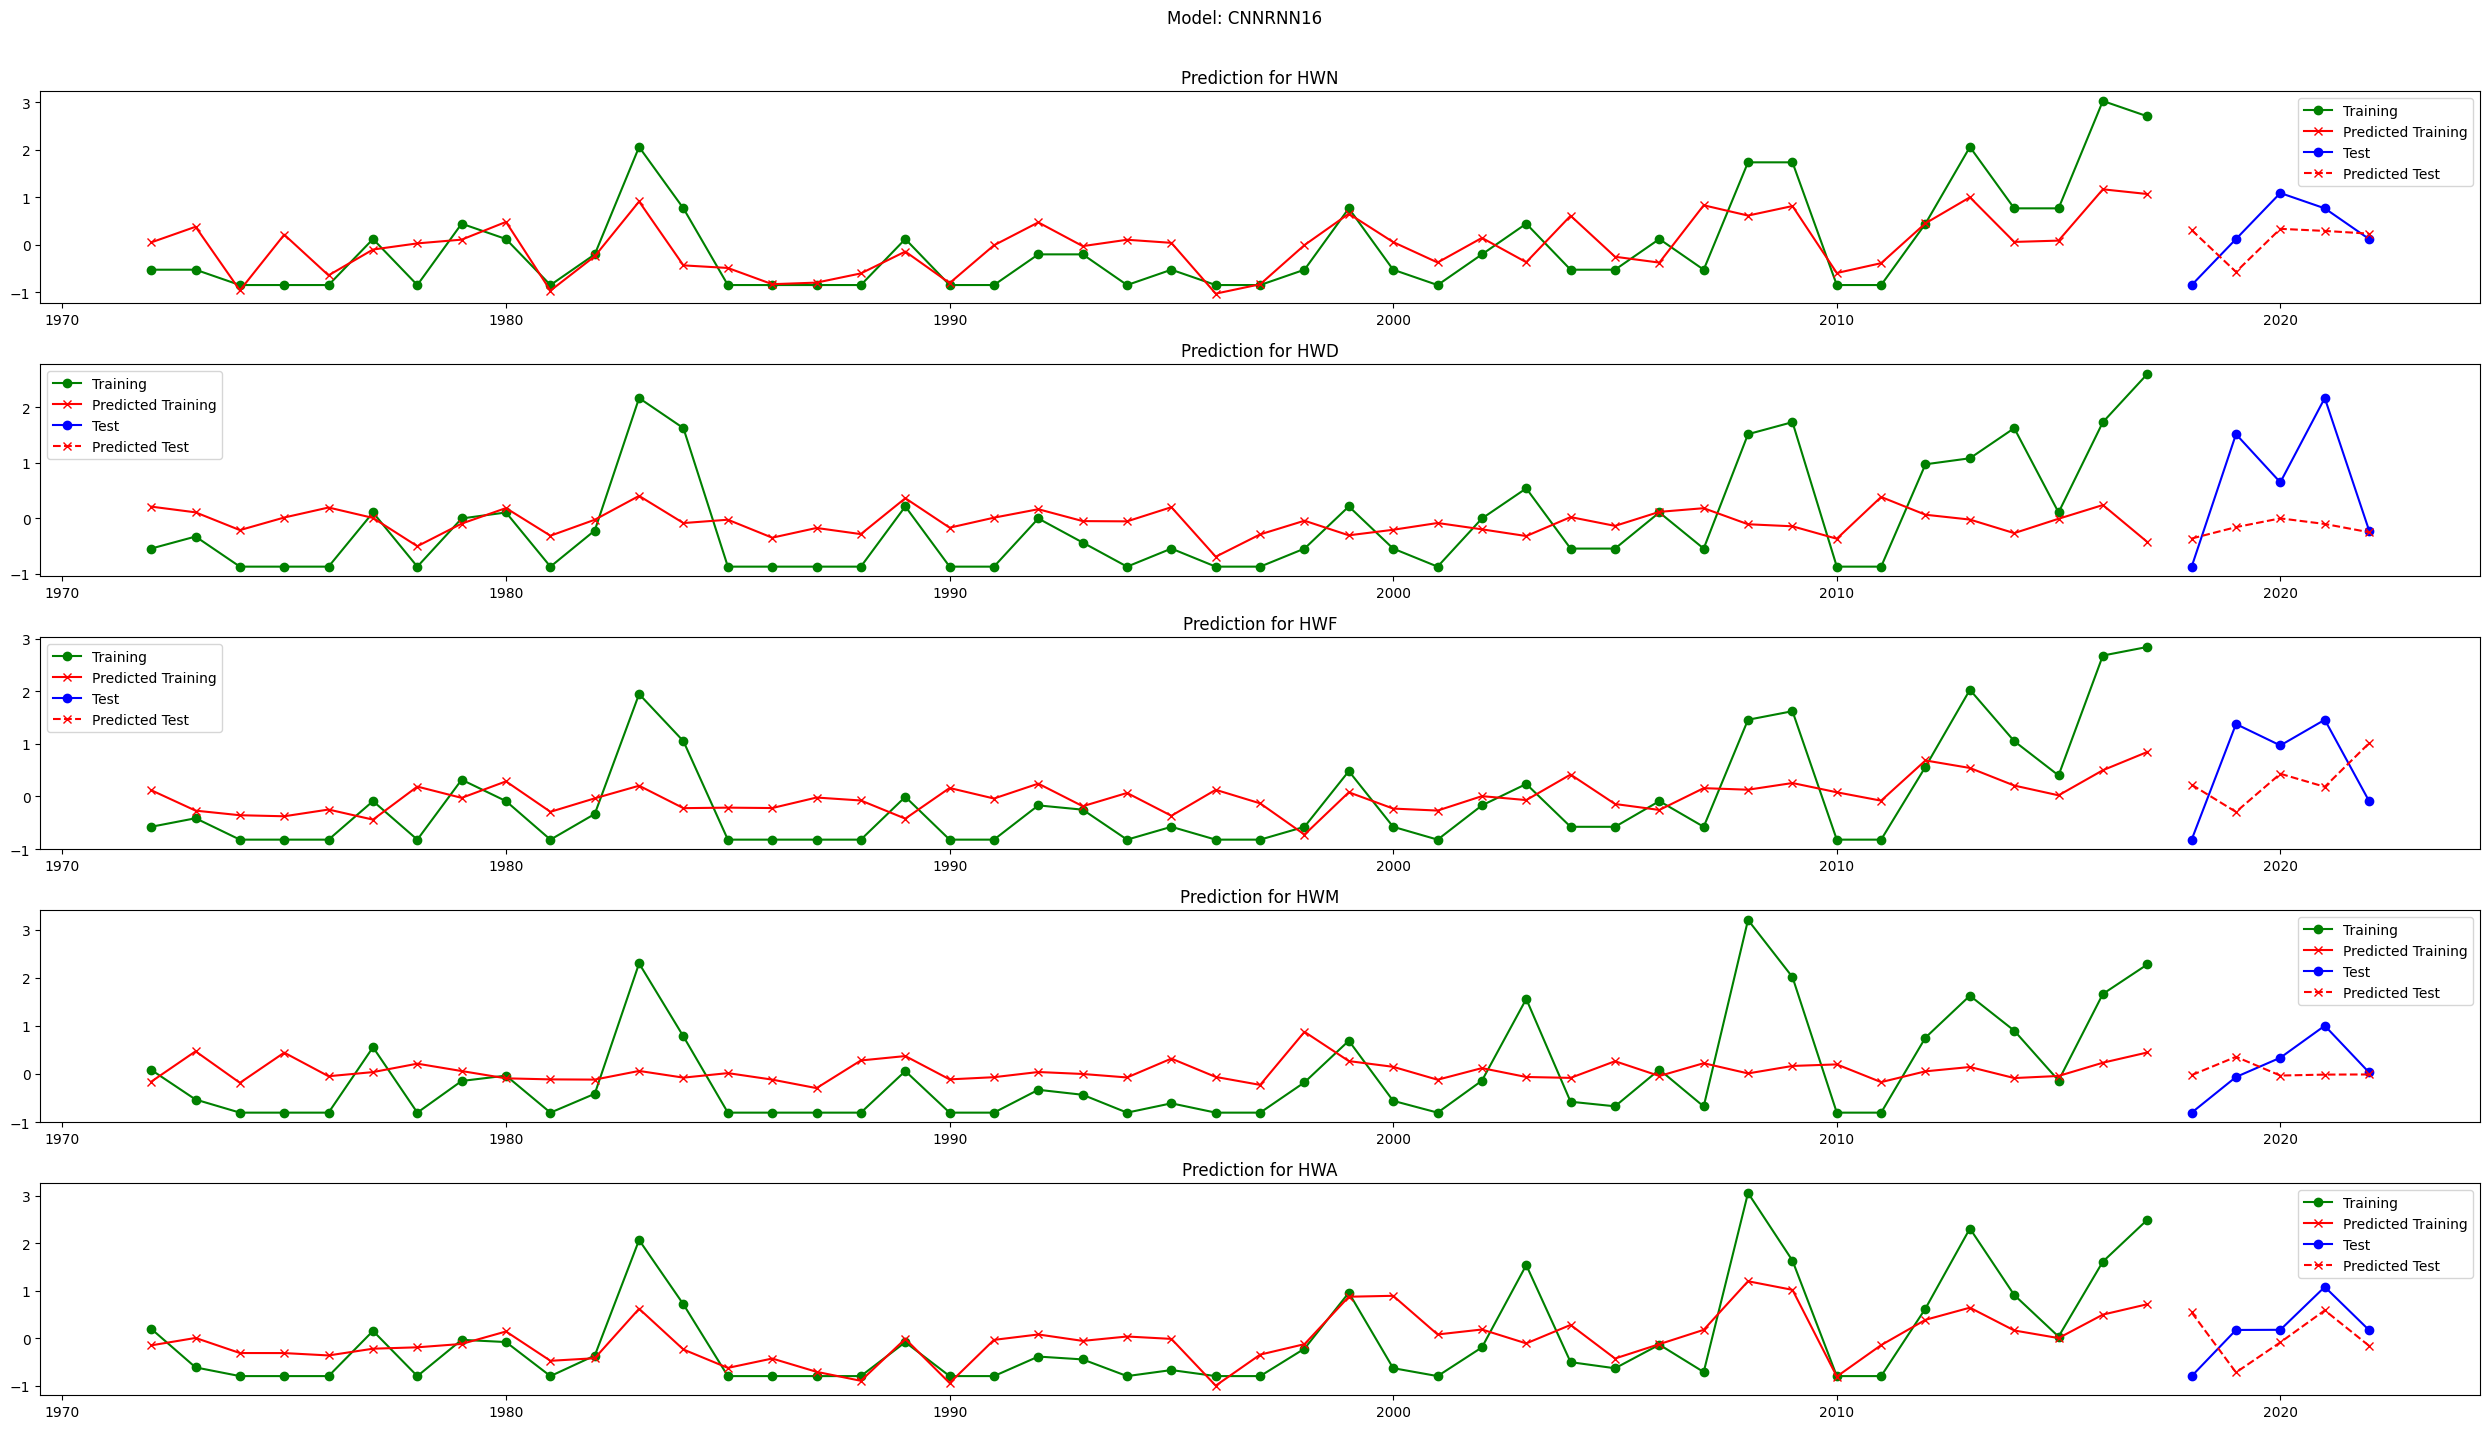

In [ ]:
id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16")
pred.compile_keras_model(loss="mse")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

## Relevance function sensibility

In [10]:
def piecewise_linear_phi(y, bounds):
    x1, x2, x3, x4 = tf.unstack(bounds)
    iqr = (x3-x2)
    x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4, y5, y6, y7 = 0, 0, 0.18, 0.5, 0.82, 1, 1
    return tf.where(
        y <= x1, tf.zeros_like(y),
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, y4 + (y4-y3)/(x4-x3)*(y-x4),
                    tf.where(
                        y <= x5, y5 + (y5-y4)/(x5-x4)*(y-x5),
                        tf.where(
                            y <= x6, y6 + (y6-y5)/(x6-x5)*(y-x6), 
                            tf.where(
                                y <= x7, tf.ones_like(y), tf.ones_like(y) 
                            )
                        )
                    )
                )
            )
        )
    )

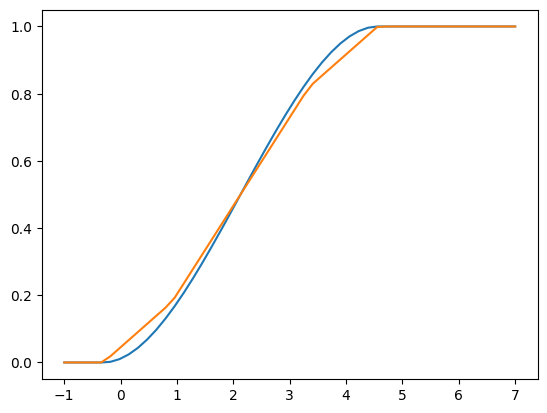

In [13]:
x = np.linspace(-1, 7)

plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi(x, bounds))

Epoch 1/200
6/6 [==============================] - 16s 627ms/step - loss: 29.9997 - mae: 0.7239 - val_loss: 22.4511 - val_mae: 0.7664
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 28.3091 - mae: 0.7071 - val_loss: 21.8770 - val_mae: 0.7637
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 28.7173 - mae: 0.6834 - val_loss: 21.2532 - val_mae: 0.7604
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 26.3792 - mae: 0.6861 - val_loss: 20.7885 - val_mae: 0.7579
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 25.8512 - mae: 0.6802 - val_loss: 20.4356 - val_mae: 0.7571
Epoch 6/200
6/6 [==============================] - 0s 8ms/step - loss: 24.9407 - mae: 0.6877 - val_loss: 20.0359 - val_mae: 0.7579
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 24.3850 - mae: 0.6745 - val_loss: 19.6202 - val_mae: 0.7593
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 23.5142 -

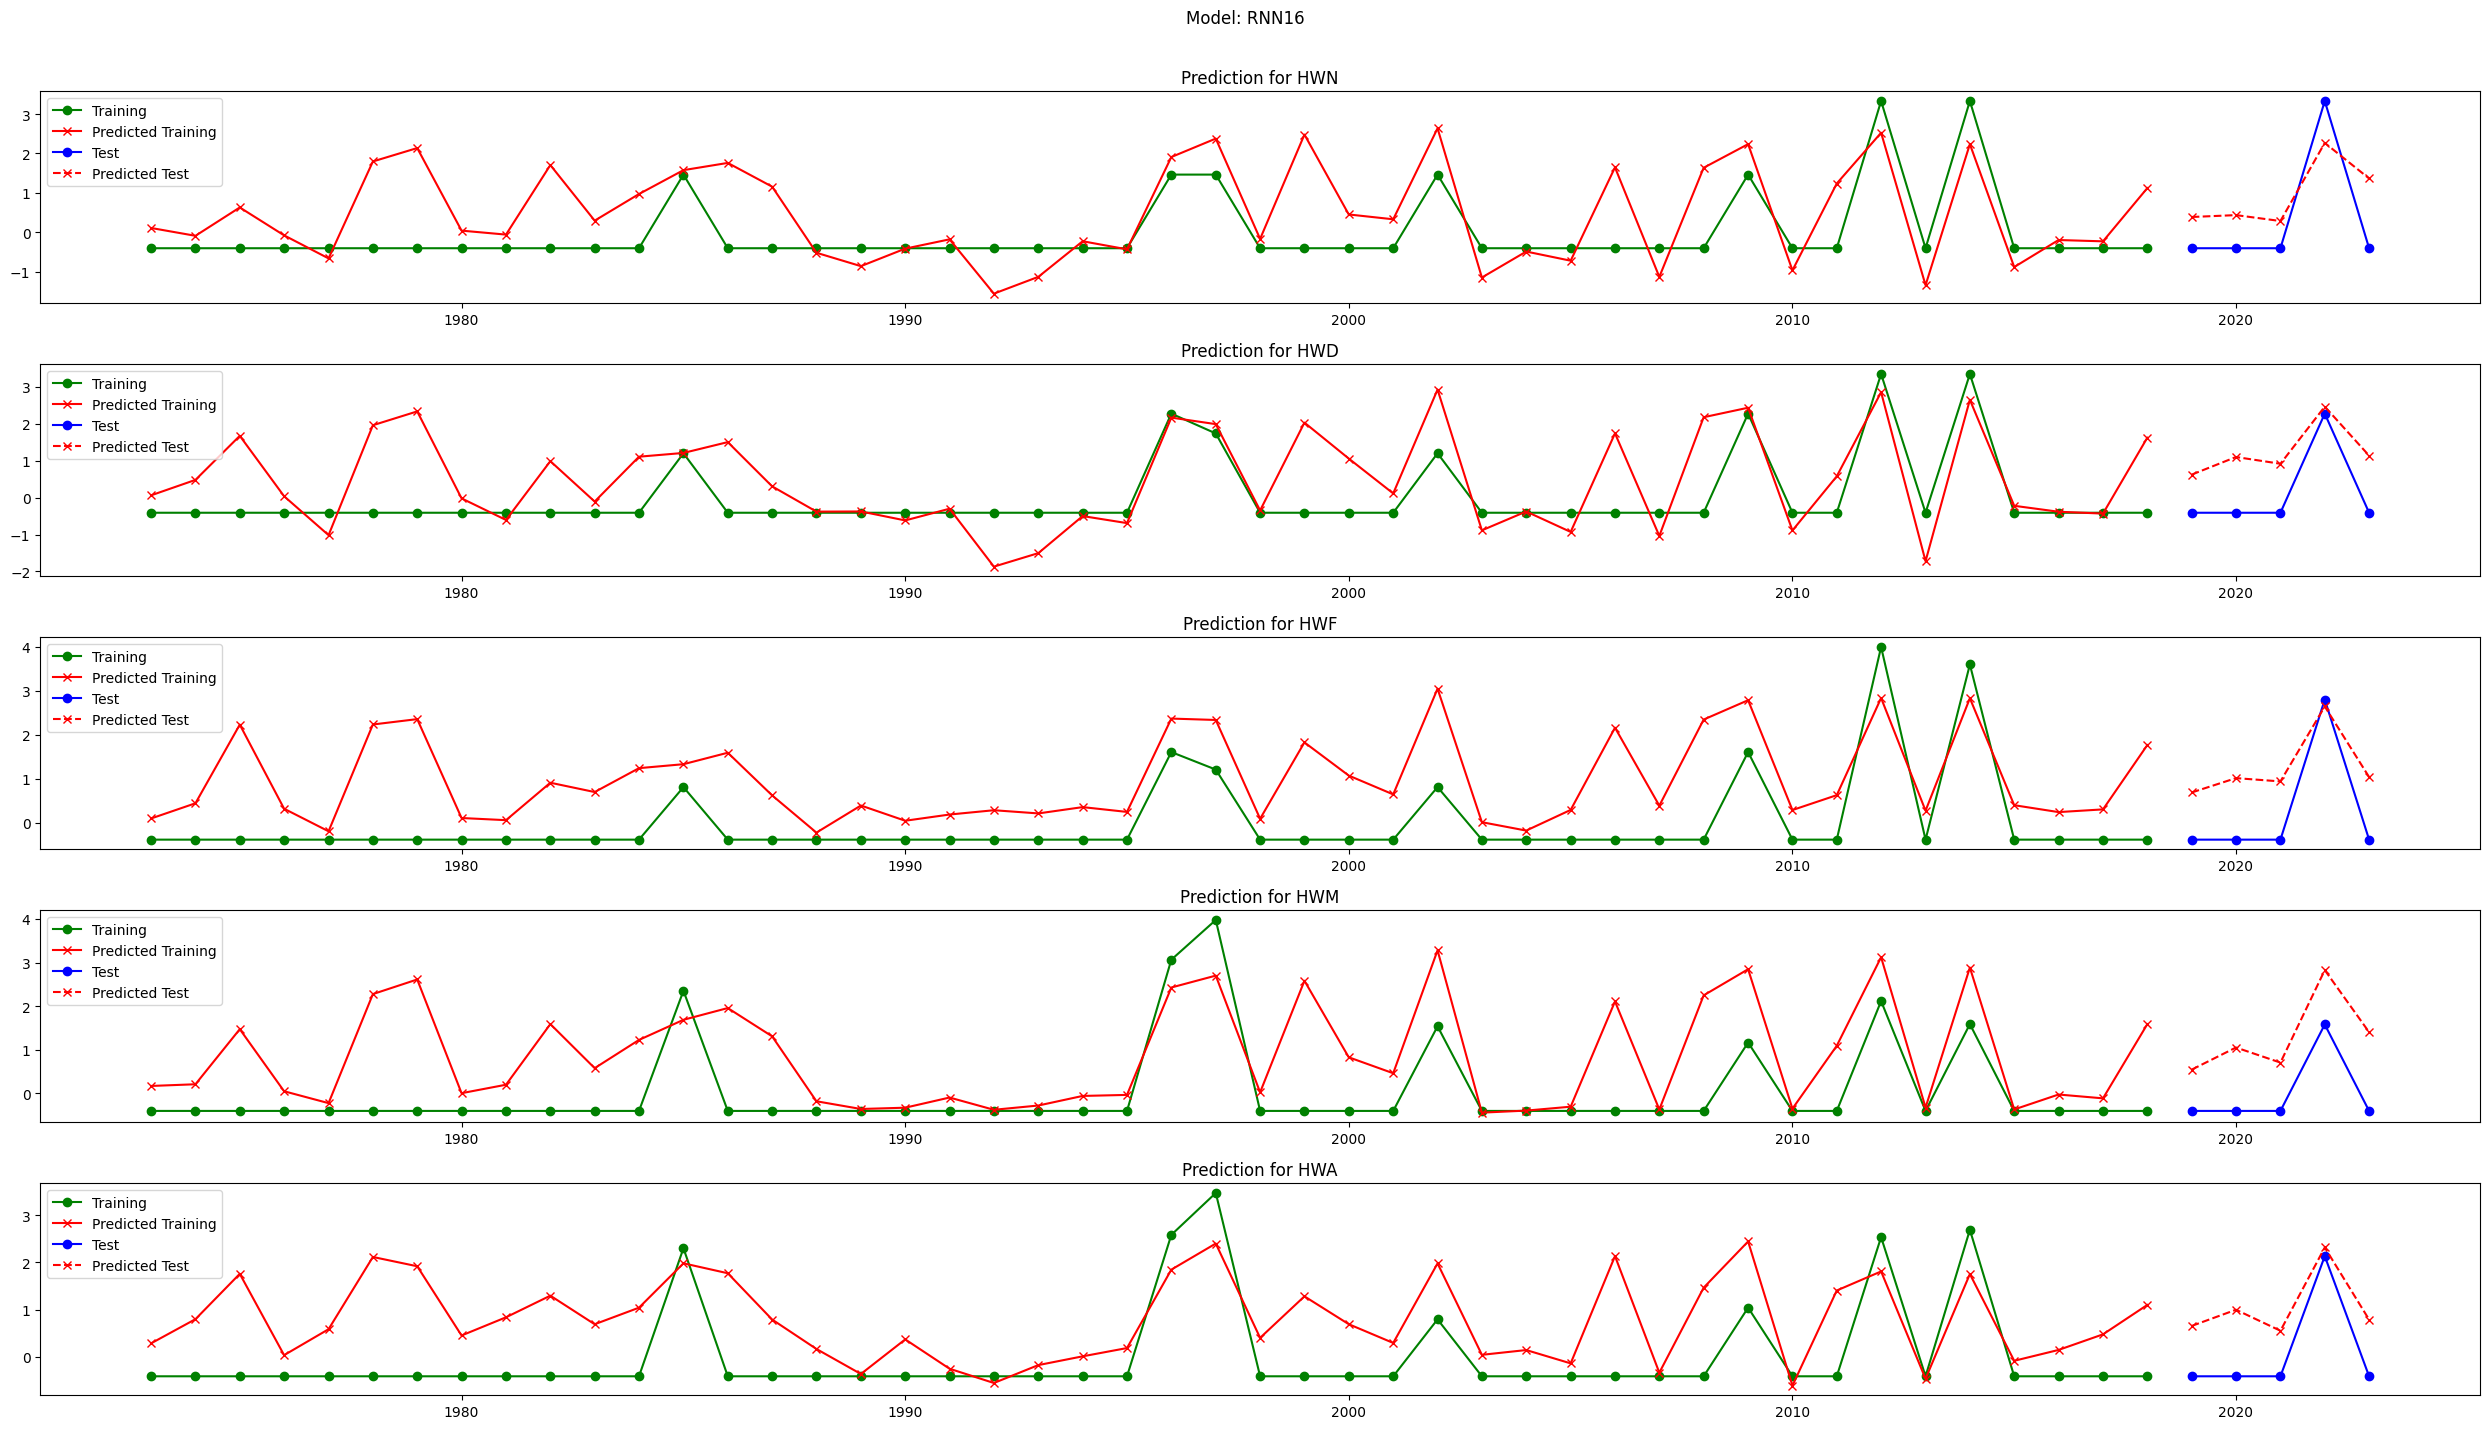

In [16]:
loss_fn = SERA(bounds=bounds,T=100)

id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
    SimpleRNN(16, activation="tanh", input_shape=(1, len(data.columns) - 5)),
    Dropout(0.1),  # Regularization
    Dense(8, activation="relu"),
    Dense(5)  # Predict 1 indices
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="RNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

Epoch 1/200
6/6 [==============================] - 16s 729ms/step - loss: 15.9391 - mae: 0.9365 - val_loss: 5.1844 - val_mae: 1.0118
Epoch 2/200
6/6 [==============================] - 0s 8ms/step - loss: 16.2064 - mae: 0.9375 - val_loss: 4.8442 - val_mae: 0.9883
Epoch 3/200
6/6 [==============================] - 0s 8ms/step - loss: 13.8980 - mae: 0.9424 - val_loss: 4.5074 - val_mae: 0.9647
Epoch 4/200
6/6 [==============================] - 0s 8ms/step - loss: 13.6070 - mae: 0.9247 - val_loss: 4.1874 - val_mae: 0.9454
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 14.1866 - mae: 0.9328 - val_loss: 3.9001 - val_mae: 0.9281
Epoch 6/200
6/6 [==============================] - 0s 9ms/step - loss: 12.5274 - mae: 0.9417 - val_loss: 3.6589 - val_mae: 0.9105
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 12.4299 - mae: 0.9428 - val_loss: 3.4259 - val_mae: 0.8925
Epoch 8/200
6/6 [==============================] - 0s 8ms/step - loss: 12.9843 - mae: 0

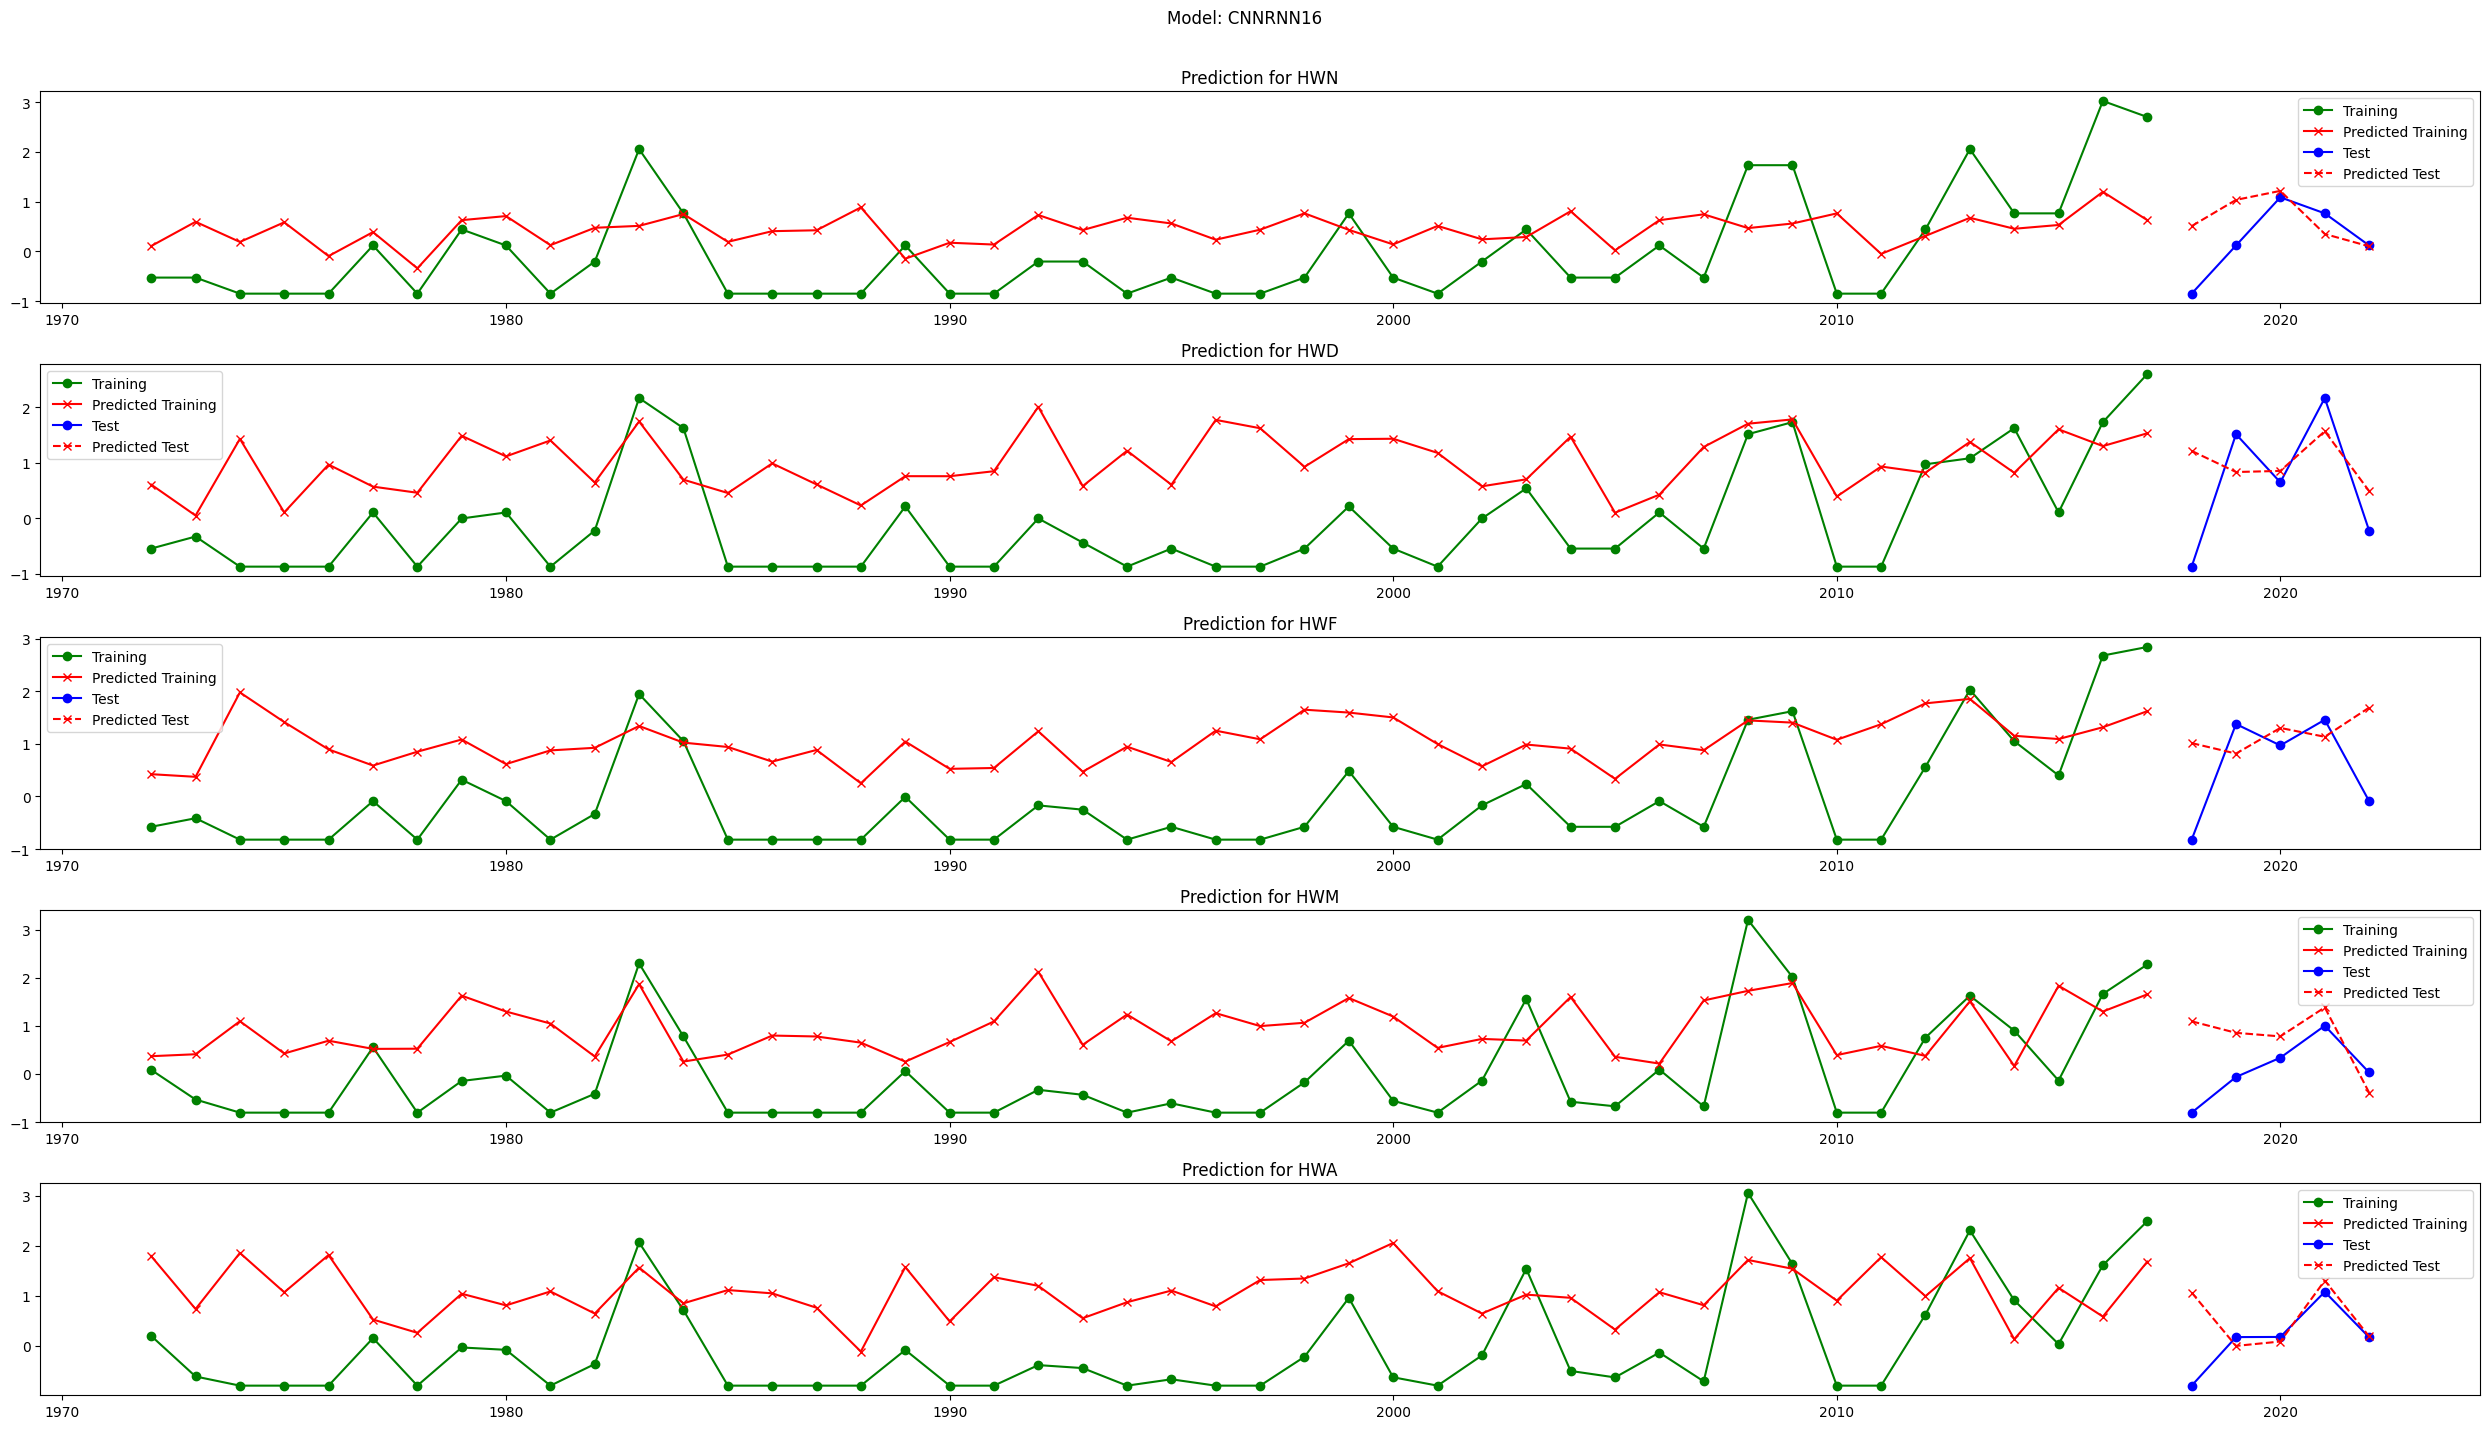

In [17]:
loss_fn = SERA(bounds=bounds,T=100)

id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = Sequential([
        Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(data.columns) - len(indices))),
        Reshape((1, 16)),  # Back to time dimension
        SimpleRNN(8, activation="tanh"),
        Dropout(0.1),
        Dense(len(indices))
    ])

pred = PredictionModel(data, season, indices, model, name_regressor="CNNRNN16", loss_fn=loss_fn)
pred.compile_keras_model(metrics="mae")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)